In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind

# Load dataset
file_path = "data_censored.csv"
data_df = pd.read_csv(file_path)

# Display basic info
print("Dataset Information:")
print(data_df.info())
print(data_df.head())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB
None
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2     

In [12]:

# Feature Selection
features = ['x1', 'x2', 'x3', 'x4', 'age']
X = data_df[features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:

# K-Means Clustering Integration
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
silhouette_kmeans = silhouette_score(X_scaled, data_df['kmeans_cluster'])
print(f"K-Means Silhouette Score: {silhouette_kmeans:.4f}")

# DBSCAN Clustering Integration
dbscan = DBSCAN(eps=0.5, min_samples=5)
data_df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)


K-Means Silhouette Score: 0.2281


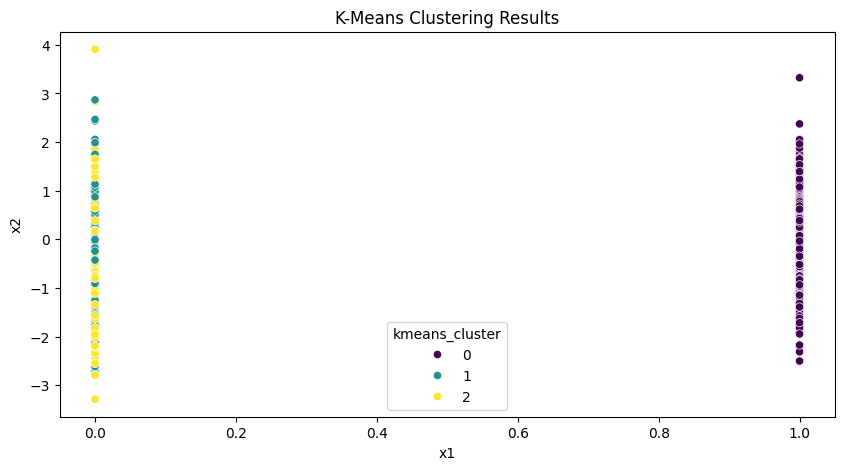

In [14]:

# Visualizing Clustering Results
plt.figure(figsize=(10,5))
sns.scatterplot(x=data_df['x1'], y=data_df['x2'], hue=data_df['kmeans_cluster'], palette='viridis')
plt.title("K-Means Clustering Results")
plt.show()


In [15]:

# Propensity Score Matching (PSM)
psm_model = LogisticRegression()
psm_model.fit(X_scaled, data_df['treatment'])
data_df['propensity_score'] = psm_model.predict_proba(X_scaled)[:, 1]


In [16]:

# Outcome Analysis by Treatment Group
treated = data_df[data_df['treatment'] == 1]
control = data_df[data_df['treatment'] == 0]

treated_outcome_rate = treated['outcome'].mean()
control_outcome_rate = control['outcome'].mean()

print(f"Outcome Rate (Treated Group): {treated_outcome_rate:.4f}")
print(f"Outcome Rate (Control Group): {control_outcome_rate:.4f}")


Outcome Rate (Treated Group): 0.0088
Outcome Rate (Control Group): 0.0207


In [17]:

# Comparing Outcomes within Clusters
for cluster in sorted(data_df['kmeans_cluster'].unique()):
    cluster_data = data_df[data_df['kmeans_cluster'] == cluster]
    treated_cluster = cluster_data[cluster_data['treatment'] == 1]
    control_cluster = cluster_data[cluster_data['treatment'] == 0]

    if len(treated_cluster) > 0 and len(control_cluster) > 0:
        t_stat, p_val = ttest_ind(treated_cluster['outcome'], control_cluster['outcome'], equal_var=False)
        print(f"Cluster {cluster}: T-Test p-value = {p_val:.4f}")


Cluster 0: T-Test p-value = 0.3158
Cluster 1: T-Test p-value = 0.4356
Cluster 2: T-Test p-value = 0.6567


In [18]:

# Insights: The impact of clustering on treatment effect
# - Clustering helps stratify the population into groups that may have different treatment effects.
# - If treatment effects vary significantly across clusters, this suggests heterogeneity in the data that traditional PSM might not capture.
